In [3]:
# !pip install  tensorflow  opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 1.4 MB/s eta 0:00:29
    --------------------------------------- 0.9/38.8 MB 11.2 MB/s eta 0:00:04
   --- ------------------------------------ 3.1/38.8 MB 28.6 MB/s eta 0:00:02
   ----- ---------------------------------- 5.7/38.8 MB 36.2 MB/s eta 0:00:01
   ------ --------------------------------- 6.1/38.8 MB 29.8 MB/s eta 0:00:02
   --------- ------------------------------ 9.3/38.8 MB 37.1 MB/s eta 0:00:01
   ------------ --------------------------- 12.5/38.8 MB 50.4 MB/s eta 0:00:01
   ---------------- ----------------------- 15.7/38.8 MB 54.7 MB/s eta 0:00:01
   --

In [1]:
import cv2 
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
#use this only when you have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH =os.path.join('data', 'positive')
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data","anchor")

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [5]:
import uuid

In [6]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\efe99e7a-2fef-11ef-b666-983b8f767b99.jpg'

In [12]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname= os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname= os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    
    cv2.imshow("Image Collection",frame)

    if cv2.waitKey(1) & 0XFF ==ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
print(dir_test.next())

b'data\\anchor\\b4509c7f-2f22-11ef-b711-983b8f767b99.jpg'


In [11]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img= tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [12]:
img = preprocess("data\\anchor\\b3530521-2f22-11ef-bb95-983b8f767b99.jpg")

In [13]:
img.numpy().max()

0.967402

In [ ]:
plt.show(img)

In [18]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img), label)

In [21]:
samples = data.as_numpy_iterator()


In [22]:
example = samples.next()

In [23]:
example

(b'data\\anchor\\44e76afa-2f22-11ef-8d53-983b8f767b99.jpg',
 b'data\\anchor\\b38026b1-2f22-11ef-84f2-983b8f767b99.jpg',
 1.0)

In [24]:
res = preprocess_twin(*example)

In [ ]:
plt.imshow(res[0])

In [ ]:
plt.imshow(res[1])

In [27]:
res[2]

1.0

In [28]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
test_data = data.skip(round(len(data)*.3))
text_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [31]:
def make_embeddings():
    inp = Input(shape=(100,100,3),name="input_image")
    c1 = Conv2D(64,(10,10),activation="relu")(inp)
    m1=MaxPooling2D(64,(2,2), padding='same')(c1)
    c2=Conv2D(128,(7,7), activation="relu")(m1)
    m2= MaxPooling2D(64,(2,2), padding="same")(c2)
    c3=Conv2D(128,(4,4), activation="relu")(m2)
    m3=MaxPooling2D(63,(2,2),padding='same')(c3)
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1= Flatten()(c4)
    d1= Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding" )

In [32]:
embedding = make_embeddings()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()


    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    

In [35]:
l1= L1Dist()

In [36]:
l1

In [37]:
def make_siamese_model():
    input_image= Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_image',shape=(100,100,3))

    siamese_layer=L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    classifier = Dense(1, activation ='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image], outputs = classifier, name="SiameseNetwork")

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_image[0

In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

opt = tf.keras.optimizers.Adam(1e-4)

In [41]:
checkpoint_dir ="./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [42]:
@tf.function
def train_step(batch):

    #recording all the operations
    with tf.GradientTape() as tape:
        #grt anchor and +ve/-ve image
        X=batch[:2]
        y=batch[2]

        yhat= siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)

    grad= tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))


    return loss


In [43]:
# building training loop

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print("\nEpoch {}/{}".format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))


        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [49]:
epoch = 10

In [50]:
train(train_data,epoch)


Epoch 1/10
27/27 [==============================] - 998s 37s/step

Epoch 2/10
27/27 [==============================] - 939s 35s/step

Epoch 3/10
27/27 [==============================] - 904s 33s/step

Epoch 4/10
27/27 [==============================] - 945s 35s/step

Epoch 5/10
27/27 [==============================] - 1032s 38s/step

Epoch 6/10
27/27 [==============================] - 1232s 46s/step

Epoch 7/10
27/27 [==============================] - 30549s 1173s/step

Epoch 8/10
27/27 [==============================] - 1740s 64s/step

Epoch 9/10
27/27 [==============================] - 1150s 42s/step

Epoch 10/10
27/27 [==============================] - 4531s 173s/step


In [52]:
from tensorflow.keras.metrics import Precision, Recall

In [60]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [61]:
yhat = siamese_model.predict([test_input, test_val])
yhat

1/1 [==============================] - 4s 4s/step


array([[0.9999566 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9995696 ],
       [0.8454938 ],
       [0.9999999 ],
       [1.        ],
       [1.        ],
       [0.9996518 ],
       [0.9973277 ],
       [1.        ],
       [0.99957204],
       [0.9999596 ],
       [0.99904233]], dtype=float32)

In [62]:
[1 if prediction >0.5 else 0 for prediction in yhat]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [63]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [64]:
#recall

m = Recall()
#calculaing recall 
m.update_state(y_true,yhat)
m.result().numpy()

1.0

In [65]:
m = Precision()
#calculaing precision 
m.update_state(y_true,yhat)
m.result().numpy()


1.0

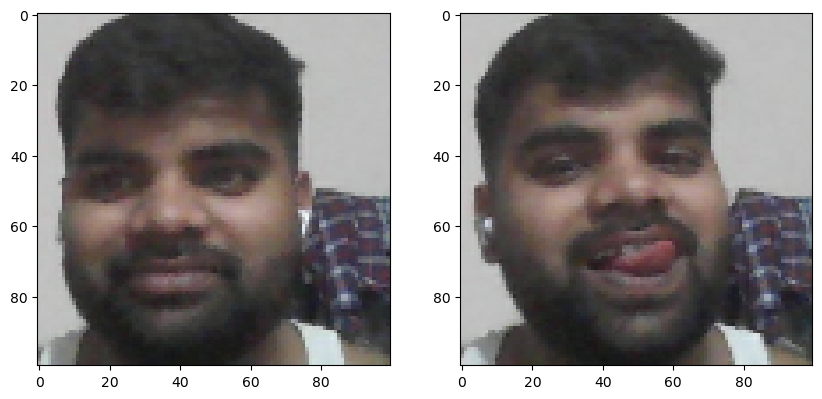

In [66]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

In [67]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [68]:
#loading model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist,'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [69]:
model.predict([test_input,test_val])

1/1 [==============================] - 6s 6s/step


array([[0.9999566 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9995696 ],
       [0.8454938 ],
       [0.9999999 ],
       [1.        ],
       [1.        ],
       [0.9996518 ],
       [0.9973277 ],
       [1.        ],
       [0.99957204],
       [0.9999596 ],
       [0.99904233]], dtype=float32)